<a href="https://colab.research.google.com/github/kvolle/pose_from_warp/blob/master/Warping_for_PoseNet_Freiburg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Comma AI Speed Challenge**

  This notebook will contain (hopefully) all of the functions you need to import the data into your model.

  ***Be sure to train with GPU acceleration enabled***

**Import Statements**

In [ ]:
!pip install tensorflow_graphics

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow import keras
from datetime import datetime
import csv
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Custom Data Generator**

This works (I think) for giving two sequential images to a Keras Functional model as well as the velocity associated with the second image.

At this point, don't worry about how this works. If you need something changed or fixed, just ask. This is the boring part anyways.

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, custom_indices, batch_size=32,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()
        self.direct = "./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/"
        self.indexes = custom_indices

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        # Generate data
        X, y = self.__data_generation(index)#batch)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs)-5)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, names_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x1_full = np.empty((0, 480, 640, 4))
        x2_full = np.empty((0, 480, 640, 4))
        y_full = np.empty((0, 4, 4))
        for name in names_temp:
          x1 = np.load(self.direct+"/images/rgbd_%d.npy"%int(self.list_IDs[name][0]))
          x1 = np.reshape(x1,(1,480, 640, 4))
          x2 = np.load(self.direct+"images/rgbd_%d.npy"%int(self.list_IDs[name+5][0]))
          x2 = np.reshape(x2,(1,480, 640, 4))
          x1 = x1/255.
          x1 = x1 - np.mean(x1, axis=0)
          x2 = x2/255.
          x2 = x2 - np.mean(x2, axis=0)
          y1 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[name][0]))
          y2 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[name+5][0]))
          y = np.linalg.inv(y1).dot(y2)
          x1_full = np.concatenate((x1_full, x1))
          x2_full = np.concatenate((x2_full, x2))
          y_full = np.concatenate((y_full, np.reshape(y, (1, 4, 4)) ))

        y_quat = tfg_transformation.quaternion.from_rotation_matrix(y_full[:,0:3, 0:3])
        y_quat = np.arccos(y_quat[:,3]).reshape((-1,1))*y_quat[:,0:3]/np.linalg.norm(y_quat[:,0:3], axis=1).reshape((-1,1))
        total = tf.keras.layers.concatenate((y_quat, y_full[:,0:3,3]), dtype='float64')
        return [x1_full[:,:,:,0:3], x1_full[:,:,:,3], x2_full[:,:,:,0:3], x2_full[:,:,:,3]], total

**Define constants for image warp**

The following block of code only needs run once

In [ ]:
# Define hx, wx, h1 as the homogeneous pixel coordinates
# This appears to match the original paper's output format
height_coord = range(480)
width_coord = range(640)
hx, wx = pixel_coord = np.meshgrid(height_coord, width_coord, indexing='ij')
hx = hx.reshape((480, 640, 1))
wx = wx.reshape((480, 640, 1))
h1 = np.ones(hx.shape)

grid = np.concatenate((hx, wx, h1), axis=-1)

# Define the camera intrinsic matrix
#K = np.array([[525.,0.,319.5], [0., 525., 239.5], [0.,0.,1.]])  # This is how the rostopic defines it
K = np.array([[525.,0.,239.5], [0., 525., 319.5], [0.,0.,1.]])

# Define the camera coordinates of each piel up to a depth scale factor
unscaled_cam_coord = np.empty(grid.shape)
for i in range(480):
      for j in range(640):
        unscaled_cam_coord[i,j,:]= np.linalg.inv(K).dot(grid[i,j,:])

In [ ]:
def wrap_image(image1, depth1, delta_pose):
  # This function takes an image and depth map and predicts the view after a transformation by delta_pose
  # What would image1 taken at the location after delta_pose look like? Should match image2
  camera_coord = depth1.reshape((307200, 1))*unscaled_cam_coord.reshape(307200, 3)
  homog_camera_coord = np.concatenate( (camera_coord, np.ones((307200, 1)) ), axis=1 )


  new_homog_camera_coord = np.empty(homog_camera_coord.shape)
  new_pixel_coord = np.empty((307200, 3))
  pixel_list = np.empty((307200,2))
  for i in range(307200):
    new_homog_camera_coord[i, :] = delta_pose.dot(homog_camera_coord[i, :])
    new_homog_camera_coord[i, :] = new_homog_camera_coord[i, :]/new_homog_camera_coord[i, 2]
    #new_pixel_coord[i, :] = K.dot(delta_pose.dot(new_homog_camera_coord[i, :])[0:3])
    new_pixel_coord[i, :] = K.dot(new_homog_camera_coord[i,0:3])
    pixel_list[i,:] = new_pixel_coord[i, 0:2]
  #pixel_list = new_homog_camera_coord[:,0:2].reshape((480,640,2))
  return tfa.image.interpolate_bilinear(grid=image1.reshape((1, 480, 640, 3)), query_points=pixel_list.reshape((1, 307200,2)) )
  #return tfa.image.resampler(data = image1.reshape(1,480, 640, 3), warp=pixel_list.reshape(1,480,640,2))

In [ ]:
def pixel_map(image1, depth1, delta_pose):
  # This function takes an image and depth map and predicts the view after a transformation by delta_pose
  # What would image1 taken at the location after delta_pose look like? Should match image2
  camera_coord = depth1.reshape((307200, 1))*unscaled_cam_coord.reshape(307200, 3)
  homog_camera_coord = np.concatenate( (camera_coord, np.ones((307200, 1)) ), axis=1 )


  new_homog_camera_coord = np.empty(homog_camera_coord.shape)
  new_pixel_coord = np.empty((307200, 3))
  pixel_list = np.empty((307200,2))
  for i in range(307200):
    new_homog_camera_coord[i, :] = delta_pose.dot(homog_camera_coord[i, :])
    new_homog_camera_coord[i, :] = new_homog_camera_coord[i, :]/new_homog_camera_coord[i, 2]
    #new_pixel_coord[i, :] = K.dot(delta_pose.dot(new_homog_camera_coord[i, :])[0:3])
    #pixel_list[i,:] = new_pixel_coord[i, 0:2]
  return new_homog_camera_coord[:,0:2].reshape((480,640,2))
  return new_homog_camera_coord.reshape((480,640,4))#pixel_list.reshape((480,640,2))

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  1.5]
 [0.  0.  0.  1. ]]


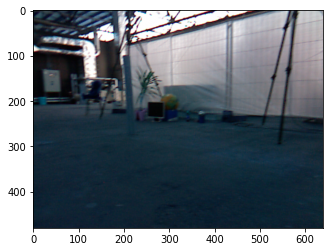

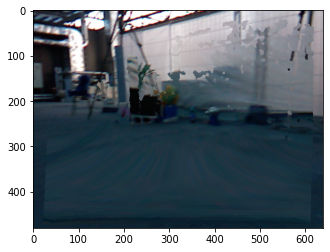

In [ ]:
x = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/images/rgbd_10870.npy")
p1 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/pose/htm_10760.npy")
p2 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/pose/htm_10765.npy")
#dp = np.linalg.inv(p1).dot(p2)
dp = np.eye(4)
dp[2,3] = 1.5
image1 = x[:,:,0:3]/255.
depth1 = x[:,:,3]*5./255.
depth1 = np.where(depth1==0,10., depth1)

hmm = wrap_image(image1, depth1, dp)

print(dp)
hmm = tf.reshape(hmm, (480,640,3))
plt.figure()
plt.imshow(image1)
plt.figure()
plt.imshow(hmm)


In [ ]:
"""

hmm2 = pixel_map(depth1, depth1, dp)
plt.figure()
plt.plot(hmm2[101,:,0])
plt.plot(hmm2[101,:,1])
plt.plot(hmm2[101,:,2])
plt.figure()
plt.plot(hmm2[275:450,99,0])
plt.plot(hmm2[275:450,99,1])
plt.plot(hmm2[275:450,99,2])

plt.figure()
plt.imshow(hmm2)
#plt.figure()
#plt.imshow(hmm2[:,:,0])
#plt.figure()
#plt.imshow(hmm2[:,:,1])
#plt.figure()
#plt.imshow(hmm2[:,:,2])
"""

**Define custom loss function**

This is not well tested, neither is it optimized. You might not even want to use this function.

Keras backend functions are a powerful tool for writing custom loss functions. To define a loss function it just has to accept *y_true* and *y_pred* as arguments and return a float.

To use your new loss function, change the argument in *model.compile()*.

In [ ]:
def mse_trans(y_true, y_pred):
  #print("y_true: " + y_true.shape)
  #print("y_pred: " + y_pred.shape)
  return tf.keras.backend.mean(tf.keras.backend.square(y_true[:,3:6] - y_pred))

In [ ]:
def mean_sq_err(y_true, y_pred):
  #y_pred = 15. + y_pred*15.
  return tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred)) #+ metric_var(y_true, y_pred)#1./(0.001+tf.keras.backend.var(y_pred))

In [ ]:
def mean_psuedo_huber(y_true, y_pred):
  scale = 10
  huber = scale*scale*(tf.keras.backend.sqrt(1+tf.keras.backend.square((y_true-y_pred)/scale)) - 1)
  return tf.keras.backend.mean(huber)

In [ ]:
def metric_var(y_true, y_pred):
  #return 1./(0.001+tf.keras.backend.var(y_pred))
  epsilon = 0.001
  return tf.keras.backend.maximum((epsilon + tf.keras.backend.var(y_true))/(epsilon+tf.keras.backend.var(y_pred)), 1)

In [ ]:
def metric_mean(y_true, y_pred):
  return tf.keras.backend.mean(tf.keras.backend.square(y_true))

In [ ]:
def mean_psuedo_huber_var(y_true, y_pred):
  scale_factor = 10.
  return scale_factor1*mean_psuedo_huber(y_true, y_pred) + metric_var(y_true, y_pred)

**Define the test-train split and create the Data Generator**

In [ ]:
with open("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/indices.csv", newline='') as f:
  reader = csv.reader(f)
  list_IDs = list(reader)
indexes = np.arange(len(list_IDs)-5)
np.random.shuffle(indexes)

# Define train/test split
train_portion = 0.8

train_indices = indexes[0:int(np.floor(len(indexes)*train_portion))]
train_IDs = [list_IDs[i] for i in train_indices]

valid_indices = indexes[int(np.floor(len(indexes)*train_portion)):]
valid_IDs = [list_IDs[i] for i in valid_indices]

training_generator = DataGenerator(list_IDs = train_IDs, custom_indices = np.arange(len(train_IDs)), batch_size=16, shuffle=True )
validation_generator = DataGenerator(list_IDs = valid_IDs, custom_indices = np.arange(len(valid_IDs)), batch_size=16, shuffle=True )

**Define the input layers**

In [ ]:
input_A = tf.keras.layers.Input(shape=(480, 640, 3), name="first_image")
depth_A = tf.keras.layers.Input(shape=(480, 640, 1), name="first_depth")
input_B = tf.keras.layers.Input(shape=(480, 640, 3), name="second_image")
depth_B = tf.keras.layers.Input(shape=(480, 640, 1), name="second_depth")

**Create HTM from 6x1**

Using Euler for now, will likely switch to log-quat

In [ ]:
def pose_vec2mat(pose):
  return 0

**Define projection function**
Modified from original paper's source code:
https://github.com/tinghuiz/SfMLearner/

In [ ]:
def projective_inverse_warp(img, depth, pose, intrinsics):
  """Inverse warp a source image to the target image plane based on projection.
  Modified from original paper's source code:
  https://github.com/tinghuiz/SfMLearner/
  Args:
    img: the source image [batch, height_s, width_s, 3]
    depth: depth map of the target image [batch, height_t, width_t]
    pose: target to source camera transformation matrix [batch, 6], in the
          order of tx, ty, tz, rx, ry, rz
    intrinsics: camera intrinsics [batch, 3, 3]
  Returns:
    Source image inverse warped to the target image plane [batch, height_t,
    width_t, 3]
  """
  #batch, height, width, _ = img.get_shape().as_list()
  # Convert pose vector to matrix
  pose = pose_vec2mat(pose)
  # Construct pixel grid coordinates
  pixel_coords = meshgrid(batch, height, width)
  # Convert pixel coordinates to the camera frame
  cam_coords = pixel2cam(depth, pixel_coords, intrinsics)
  # Construct a 4x4 intrinsic matrix (TODO: can it be 3x4?)
  filler = tf.constant([0.0, 0.0, 0.0, 1.0], shape=[1, 1, 4])
  filler = tf.tile(filler, [batch, 1, 1])
  intrinsics = tf.concat([intrinsics, tf.zeros([batch, 3, 1])], axis=2)
  intrinsics = tf.concat([intrinsics, filler], axis=1)
  # Get a 4x4 transformation matrix from 'target' camera frame to 'source'
  # pixel frame.
  proj_tgt_cam_to_src_pixel = tf.matmul(intrinsics, pose)
  src_pixel_coords = cam2pixel(cam_coords, proj_tgt_cam_to_src_pixel)
  output_img = bilinear_sampler(img, src_pixel_coords)
  return output_img


**Define the model**

This model is a particularly ridiculous placeholder. Make yours better

In [ ]:
out_dim = 3
concat = tf.keras.layers.concatenate([input_A, input_B])
conv1 = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu')(concat)
conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu')(conv1)
conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation='relu')(conv2)
conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2), activation='relu')(conv3)
conv5 = tf.keras.layers.Conv2D(256,(3, 3), padding='same', strides=(2, 2), activation='relu')(conv4)
conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', strides=(2, 2), activation='relu')(conv5)
conv7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', strides=(2, 2), activation='relu')(conv6)
readout = tf.keras.layers.Conv2D(out_dim, (1, 1))(conv7)
readout = 10.*tf.keras.layers.AveragePooling2D((4,5))(readout)
readout = tf.keras.layers.Flatten()(readout)
#warped_image = warp(input_A, depth_A, readout)
#print(input_A.shape)
#print(warped_image.shape)
model = tf.keras.models.Model(inputs=[input_A, depth_A, input_B, depth_B], outputs=readout)

**How ridiculous? Run this next cell and find out.**

(Note how many parameters there are, at least it trains fast)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_image (InputLayer)        [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
second_image (InputLayer)       [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 480, 640, 6)  0           first_image[0][0]                
                                                                 second_image[0][0]               
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 16) 4720        concatenate[0][0]            

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

**Declare the optimizer and loss function, then compile your *less ridiculous*  model**

In [ ]:
_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#model.compile(optimizer=_optimizer, loss = mean_sq_err,  metrics=[metric_mean, mean_sq_err])
model.compile(optimizer=_optimizer, loss =mse_trans, metrics = metric_mean)

**Train using the fit_generator**

In [ ]:
%load_ext tensorboard

In [ ]:
logdir = "./drive/My Drive/SpeedChallenge/Logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=1250)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./drive/My Drive/SpeedChallenge/CheckFreiburg/3_dim{epoch}.h5", save_weights_only=True,  verbose=0)

In [ ]:
#model.fit_generator(generator=training_generator, epochs=10, verbose=1, initial_epoch=0,callbacks=[tensorboard_callback, cp_callback])

In [ ]:
model.fit(training_generator, epochs=25, verbose=1, initial_epoch=0, callbacks=[tensorboard_callback, cp_callback], validation_data = validation_generator)

Epoch 1/25
59/59 [==============================] - 568s 10s/step - loss: 0.6335 - metric_mean: 0.4933 - val_loss: 0.6725 - val_metric_mean: 0.4876
Epoch 2/25
59/59 [==============================] - 94s 2s/step - loss: 0.6328 - metric_mean: 0.4933 - val_loss: 0.6704 - val_metric_mean: 0.4914
Epoch 3/25
59/59 [==============================] - 90s 2s/step - loss: 0.6324 - metric_mean: 0.4933 - val_loss: 0.6685 - val_metric_mean: 0.4824
Epoch 4/25
59/59 [==============================] - 91s 2s/step - loss: 0.6321 - metric_mean: 0.4933 - val_loss: 0.6615 - val_metric_mean: 0.4850
Epoch 5/25
59/59 [==============================] - 92s 2s/step - loss: 0.6320 - metric_mean: 0.4933 - val_loss: 0.6560 - val_metric_mean: 0.4856
Epoch 6/25
59/59 [==============================] - 90s 2s/step - loss: 0.6319 - metric_mean: 0.4933 - val_loss: 0.6696 - val_metric_mean: 0.4888
Epoch 7/25
59/59 [==============================] - 90s 2s/step - loss: 0.6318 - metric_mean: 0.4933 - val_loss: 0.6728 - 

In [ ]:
training_generator[0][1]

In [ ]:
#model.load_weights("./drive/My Drive/SpeedChallenge/CheckFreiburg/removed_activations_changed_pool25.h5")
model.load_weights("./drive/My Drive/SpeedChallenge/CheckFreiburg/best_25.h5", by_name=True, skip_mismatch=False)

In [ ]:
x1 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/images/rgbd_10760.npy")/255.
x2 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/images/rgbd_10765.npy")/255.
p1 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/pose/htm_10760.npy")
p2 = np.load("./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/pose/htm_10765.npy")
delta_p = np.linalg.inv(p1).dot(p2)

q = tfg_transformation.quaternion.from_rotation_matrix(delta_p[0:3, 0:3])

print(q)
print(delta_p[0:3,3])
y = model.predict([x1[:,:,0:3].reshape(1,480,640,3), x1[:,:,3].reshape(1,480,640,1), x2[:,:,0:3].reshape(1,480,640,3), x2[:,:,3].reshape(1,480,640,1)])
print(y)

NameError: ignored

In [ ]:
model.evaluate(validation_generator, verbose=1)

InvalidArgumentError: ignored